# NN implemetation with Keras

## Imports

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder


## Utils

In [18]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history.

    Parameters:
    --------
    - history: History object returned by model.fit().
    """

    # Extract data from the history object
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    
    # Determine the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plot the training and validation loss
    plt.figure(figsize=(12, 5))  # Create a figure with a specific size
    plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')  # Plot training loss
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')  # Plot validation loss if available
    plt.title('Training and Validation Loss')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Loss')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)  # Create a subplot (1 row, 2 columns, 2nd plot)
    if train_acc:
        plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')  # Plot training accuracy if available
    if val_acc:
        plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')  # Plot validation accuracy if available
    plt.title('Training and Validation Accuracy')  # Set the title of the plot
    plt.xlabel('Epochs')  # Set the x-axis label
    plt.ylabel('Accuracy')  # Set the y-axis label
    plt.legend()  # Add a legend to the plot
    plt.grid(True)  # Add a grid to the plot
    
    # Display the plots
    plt.show()


In [19]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Generate all combinations of hyperparameters based on specified ranges and steps.

    Parameters
    ---------
    - param_ranges: Dictionary with hyperparameter names as keys.
                         Each value is a tuple (start, stop, step).

    Returns
    ---------
    - List of dictionaries with all possible combinations.
    """
    # Create a dictionary where each key is a hyperparameter name and each value is an array of possible values
    param_values = {
        key: np.arange(start, stop + step, step)  # Generate values from start to stop with the given step
        for key, (start, stop, step) in param_ranges.items()
    }
    
    # Generate all possible combinations of hyperparameter values
    param_combinations = list(itertools.product(*param_values.values()))
    
    # Convert each combination from a tuple to a dictionary
    return [
        dict(zip(param_values.keys(), combination))  # Create a dictionary for each combination
        for combination in param_combinations
    ]

## Data loading

In [20]:
# One-hot encoding
encoder = OneHotEncoder(categories='auto', sparse_output=False)

# Load the training and test files for each dataset from the specified path
monk1_train = pd.read_csv('../Datasets/Monks/monks-1.train', sep='\s+', header=None)
monk1_test = pd.read_csv('../Datasets/Monks/monks-1.test', sep='\s+', header=None)

monk2_train = pd.read_csv('../Datasets/Monks/monks-2.train', sep='\s+', header=None)
monk2_test = pd.read_csv('../Datasets/Monks/monks-2.test', sep='\s+', header=None)

monk3_train = pd.read_csv('../Datasets/Monks/monks-3.train', sep='\s+', header=None)
monk3_test = pd.read_csv('../Datasets/Monks/monks-3.test', sep='\s+', header=None)

# List to store the transformed datasets
monks_train = []
monks_test = []

# Dataset monk1
X1_train = monk1_train.iloc[:, 1:7].values  # Features
y1_train = monk1_train.iloc[:, 0].values    # Labels

X1_test = monk1_test.iloc[:, 1:7].values
y1_test = monk1_test.iloc[:, 0].values

# Apply the encoder to monk1
X1_train_encoded = encoder.fit_transform(X1_train)  # Fit and transform on training data
X1_test_encoded = encoder.transform(X1_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X1_train_encoded, y1_train))
monks_test.append((X1_test_encoded, y1_test))

# Dataset monk2
X2_train = monk2_train.iloc[:, 1:7].values  # Features
y2_train = monk2_train.iloc[:, 0].values    # Labels

X2_test = monk2_test.iloc[:, 1:7].values
y2_test = monk2_test.iloc[:, 0].values

# Apply the encoder to monk2
X2_train_encoded = encoder.fit_transform(X2_train)  # Fit and transform on training data
X2_test_encoded = encoder.transform(X2_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X2_train_encoded, y2_train))
monks_test.append((X2_test_encoded, y2_test))

# Dataset monk3
X3_train = monk3_train.iloc[:, 1:7].values  # Features
y3_train = monk3_train.iloc[:, 0].values    # Labels

X3_test = monk3_test.iloc[:, 1:7].values
y3_test = monk3_test.iloc[:, 0].values

# Apply the encoder to monk3
X3_train_encoded = encoder.fit_transform(X3_train)  # Fit and transform on training data
X3_test_encoded = encoder.transform(X3_test)        # Only transform on test data

# Append the encoded data and labels to the list
monks_train.append((X3_train_encoded, y3_train))
monks_test.append((X3_test_encoded, y3_test))

## Model creation

In [21]:
def create_nn(input_dim, activ_type='tanh', optim_type='SGD', reg_flag=False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, alpha=0.01):
    """
    Create a binary classification neural network with Leaky ReLU and configurable parameters.
    
    Parameters:
    ----------
    - input_dim (int): Number of input features.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size (int): Number of nodes in each hidden layer.
    - hidden_layers (int): Number of hidden layers.
    - regularization (float): L2 regularization factor.
    - momentum (float): Momentum for the SGD optimizer.
    - alpha (float): Negative slope coefficient for Leaky ReLU.
    
    Returns:
    --------
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()  # Initialize a sequential model

    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Define the input layer with the specified input dimension

    if reg_flag and activ_type == 'leaky_relu':
        # Hidden layers with Leaky ReLU and L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, kernel_regularizer=l2(regularization)))  # Add a dense layer with L2 regularization
            model.add(LeakyReLU(negative_slope=alpha))  # Add Leaky ReLU activation with specified negative slope

    elif not reg_flag and activ_type == 'leaky_relu':
        # Hidden layers with Leaky ReLU without L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size))  # Add a dense layer without regularization
            model.add(LeakyReLU(negative_slope=alpha))  # Add Leaky ReLU activation with specified negative slope

    elif reg_flag:
        # Hidden layers with specified activation function and L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type, kernel_regularizer=regularizers.l2(regularization)))  # Add a dense layer with activation and L2 regularization

    else:
        # Hidden layers with specified activation function without L2 regularization
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type))  # Add a dense layer with activation without regularization

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))  # Add the output layer with sigmoid activation for binary classification

    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)  # Default optimizer is SGD with specified learning rate and momentum

    if optim_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)  # If optimizer type is Adam, use Adam optimizer with specified learning rate

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])  # Compile the model with binary crossentropy loss and accuracy and AUC metrics
    
    return model  # Return the compiled model

## Double-k-fold cross validation

In [30]:
def double_k_fold_cross_validation(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 6, outer_k = 5, inner_k = 5, param_grid=None):
    """
    Implements Double K-Fold Cross-Validation

    Parameters
    ---------
     -   data (np.ndarray): Features of the dataset.
     -   labels (np.ndarray): Labels of the dataset.
     -   activ_type (str): Activation function type.
     -   optim_type (str): Optimizer type.
     -   reg_flag (bool): Regularization flag.
     -  in_size (int): Input size.
     -   outer_k (int): Number of folds for outer cross-validation.
     -   inner_k (int): Number of folds for inner cross-validation.
     -   param_grid (list): List of dictionaries with hyperparameters to try.
    
    Returns:
    ----------
     -   list: List of scores obtained for each outer fold.
     -   list: List of best parameters for each outer fold.
    """
    outer_scores = []
    outer_params = []
    
    # Configuration of the outer k-fold cross-validation
    out_kfold = StratifiedKFold(n_splits=outer_k, shuffle=True, random_state=42)

    # EarlyStopping callback with patience
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=param_grid[0]['patience'], min_delta = 0.05, restore_best_weights=True)

    # Outer cross-validation loop
    out_fold_no = 1
    for train_index, val_index in out_kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the outer fold
        out_X_train, out_X_val = data[train_index], data[val_index]
        out_y_train, out_y_val = labels[train_index], labels[val_index]
        
        best_params = {}
        best_score = -np.inf

        # Iterate over each set of hyperparameters in the parameter grid
        for params in param_grid:

            inner_scores = []

            # Inner cross-validation loop
            inner_fold_no = 1
            inner_kfold = StratifiedKFold(n_splits=inner_k, shuffle=True, random_state=42)

            for train_index, val_index in inner_kfold.split(out_X_train, out_y_train):
                
                # Split the dataset into training and validation sets for the inner fold
                inner_X_train, inner_X_val = out_X_train[train_index], out_X_train[val_index]
                inner_y_train, inner_y_val = out_y_train[train_index], out_y_train[val_index]

                # Create the neural network model
                model = create_nn(input_dim=in_size,
                            activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'], 
                            alpha=params['alpha'])

                # Train the model and obtain the history
                history = model.fit(inner_X_train,
                                    inner_y_train,
                                    epochs=params['epochs'],
                                    batch_size=params['batch_size'],
                                    validation_data=(inner_X_val, inner_y_val), 
                                    verbose=0,
                                    callbacks=[early_stopping])
                    
                # Append the maximum validation accuracy to inner scores
                inner_scores.append(max(history.history['val_accuracy']))
                inner_fold_no += 1
            
            # Calculate the average score for the current set of hyperparameters
            avg_score = np.mean(inner_scores)

            # Update the best score and parameters if the current average score is better
            if avg_score > best_score:
                best_score = avg_score
                best_params = params
        
        # Train the final model on the outer training set with the best hyperparameters
        final_model = create_nn(input_dim = in_size,
                                activ_type = activ_type,
                                optim_type = optim_type,
                                reg_flag = reg_flag, 
                                learning_rate=best_params['learning_rate'],
                                hidden_size = best_params['hidden_size'], 
                                hidden_layers = best_params['hidden_layers'],
                                regularization=best_params['regularization'],
                                momentum=best_params['momentum'],
                                alpha=best_params['alpha'])
        
        # Train the final model and obtain the history
        history = final_model.fit(out_X_train, out_y_train,
                                epochs=best_params['epochs'],
                                batch_size=best_params['batch_size'],
                                validation_data=(out_X_val, out_y_val),
                                verbose=0,
                                callbacks=[early_stopping])
        
        # Append the maximum validation accuracy to outer scores
        outer_scores.append(max(history.history['val_accuracy']))
        outer_params.append(best_params)
        out_fold_no += 1
    
    return outer_scores, outer_params

## K-fold cross validation

In [23]:
def k_fold_cross_validation(data, labels, activ_type='tanh', optim_type='SGD', reg_flag=False, in_size=6, params=None):
    """
    Perform k-fold cross-validation on the given dataset using a neural network model.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - in_size (int): Number of input features.
    - params (dict): Dictionary containing hyperparameters for the model.

    Returns:
    --------
    - avg_score (float): Average validation accuracy across all folds.
    - history (tf.keras.callbacks.History): Training history of the final model.
    - model (tf.keras.Model): Trained Keras model.
    """
    # Configuration of k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # EarlyStopping callback with patience
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=params['patience'], min_delta = 0.05, restore_best_weights=True)

    # Cross-validation loop
    fold_no = 1
    accuracy_per_fold = []
    for train_index, val_index in kfold.split(data, labels):
        
        # Split the dataset into training and validation sets for the current fold
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Create the neural network model
        model = create_nn(input_dim=in_size,
                          activ_type=activ_type,
                          optim_type=optim_type,
                          reg_flag=reg_flag,
                          learning_rate=params['learning_rate'], 
                          hidden_size=params['hidden_size'], 
                          hidden_layers=params['hidden_layers'], 
                          regularization=params['regularization'], 
                          momentum=params['momentum'], 
                          alpha=params['alpha'])

        # Train the model with EarlyStopping
        history = model.fit(X_train, y_train,
                            epochs=params['epochs'], 
                            batch_size=params['batch_size'], 
                            validation_data=(X_val, y_val),
                            verbose=0, 
                            callbacks=[early_stopping])

        # Get the best score (maximum validation accuracy)
        score = max(history.history['val_accuracy'])
        accuracy_per_fold.append(score)    
        fold_no += 1

    # Calculate the average score across all folds
    avg_score = np.mean(accuracy_per_fold)

    # Split the dataset into training and validation sets for the final training
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Create the neural network model for the final training
    model = create_nn(input_dim=in_size,
                      activ_type=activ_type,
                      optim_type=optim_type,
                      reg_flag=reg_flag, 
                      learning_rate=params['learning_rate'], 
                      hidden_size=params['hidden_size'], 
                      hidden_layers=params['hidden_layers'], 
                      regularization=params['regularization'], 
                      momentum=params['momentum'], 
                      alpha=params['alpha'])

    # Final training with EarlyStopping
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        callbacks=[early_stopping])

    # Return the average score, training history, and the final model
    return avg_score, history, model

## Greedy search

In [24]:
def greed_search(data, labels, activ_type='tanh', optim_type='SGD', reg_flag=False, input_size=6, param_grid=None):
    """
    Perform a greedy search over the hyperparameter grid to find the best model configurations.

    Parameters:
    ----------
    - data (np.ndarray): Features of the dataset.
    - labels (np.ndarray): Labels of the dataset.
    - activ_type (str): Activation function type for hidden layers.
    - optim_type (str): Optimizer type ('SGD' or 'Adam').
    - reg_flag (bool): Flag to indicate whether to use L2 regularization.
    - input_size (int): Number of input features.
    - param_grid (list): List of dictionaries with hyperparameters to try.

    Returns:
    --------
    - best_scores (list): List of the best scores obtained.
    - best_params_list (list): List of the best hyperparameter configurations.
    - best_models (list): List of the best trained models.
    - best_histories (list): List of the training histories of the best models.
    """
    best_scores = []  # List to store the best scores
    best_params_list = []  # List to store the best hyperparameter configurations
    best_models = []  # List to store the best models
    best_histories = []  # List to store the training histories of the best models

    # Iterate over each set of hyperparameters in the parameter grid
    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")

        # Perform k-fold cross-validation with the current set of hyperparameters
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size, params=params)
        print(f"Score : {score}")

        # Add the results to the lists
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Sort the scores in descending order and keep only the top 10
        sorted_indices = np.argsort(best_scores)[::-1]  # Get the indices that would sort the scores in descending order
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Keep only the top 10 scores
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]  # Keep only the top 10 hyperparameter configurations
        best_models = [best_models[i] for i in sorted_indices][:10]  # Keep only the top 10 models
        best_histories = [best_histories[i] for i in sorted_indices][:10]  # Keep only the top 10 training histories

    print("--------------------END GREED SEARCH------------------------------")

    # Return the top 10 best results
    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [25]:
# Initialize lists to store the best scores, parameters, models, and training histories for each dataset
best_scores = [[], [], []]  # Use a list of three elements to store the scores for each dataset
best_params_list = [[], [], []]  # List of three elements to store the best hyperparameter configurations for each dataset
best_models = [[], [], []]  # List of three elements to store the best models for each dataset
best_histories = [[], [], []]  # List of three elements to store the training histories for each dataset

# Select 100 random elements from the parameter grid without replacement
# This line is commented out because it is not used in the current implementation
# np.random.choice(param_grid, size=100, replace=False)

--------------------------------------------------MONK 1--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.3, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9429999947547912
--------------------------------------------------
Testing params: {'learning_rate': 0.3, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9839999914169312
--------------------------------------------------
Testing params: {'learning_rate': 0.3, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score : 0.9679999947547913
--------------------------------------------------
Testing params: {'learning_rate': 0.4, 'epochs': 180, 'batch_s

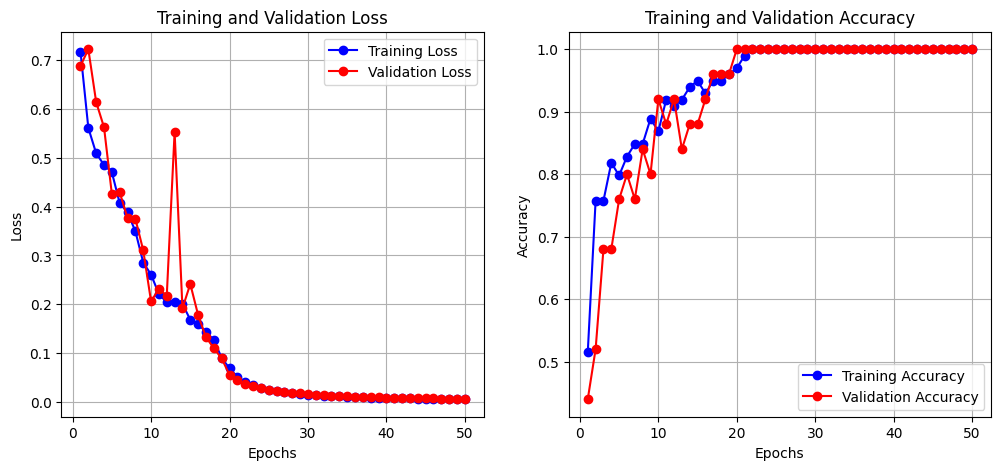

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9839999914169312


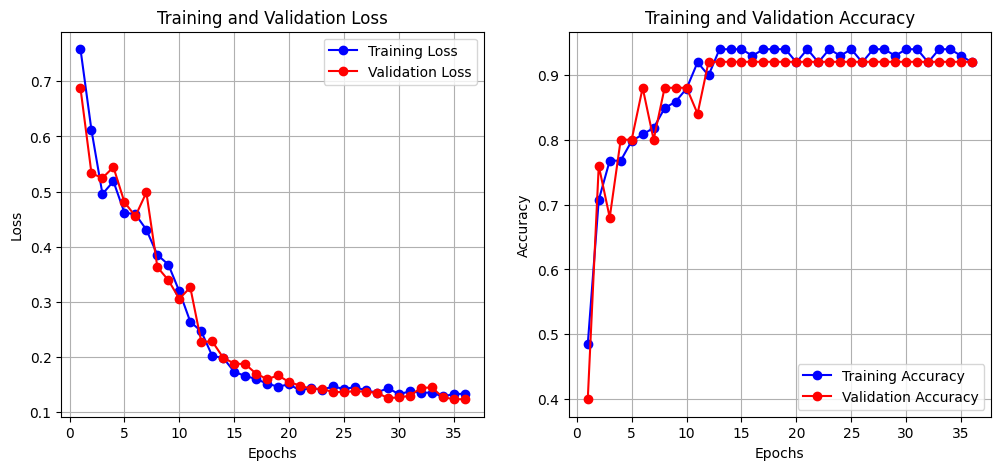

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9759999990463257


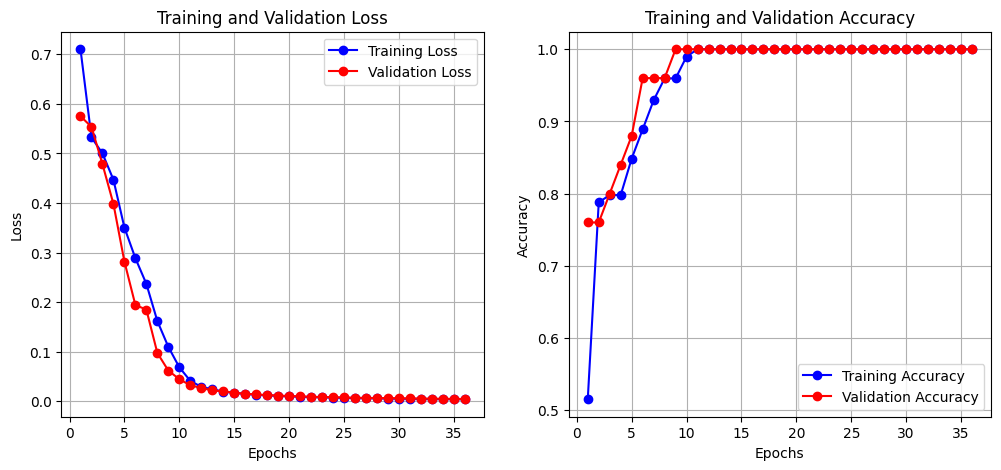

{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9680000066757202


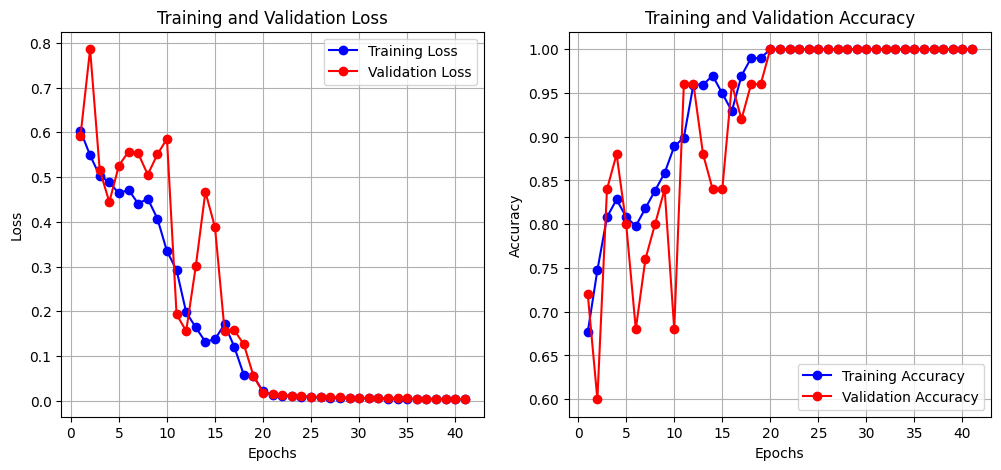

{'learning_rate': 0.3, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9679999947547913


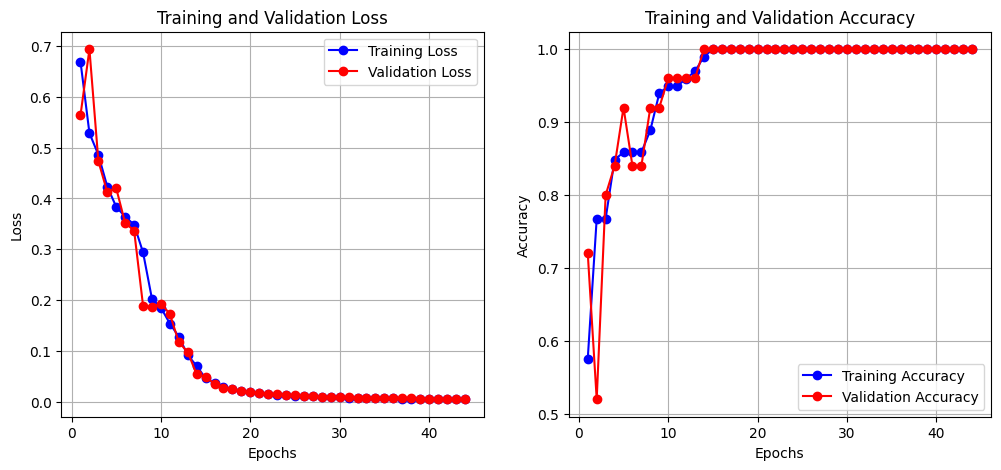

{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.959333336353302


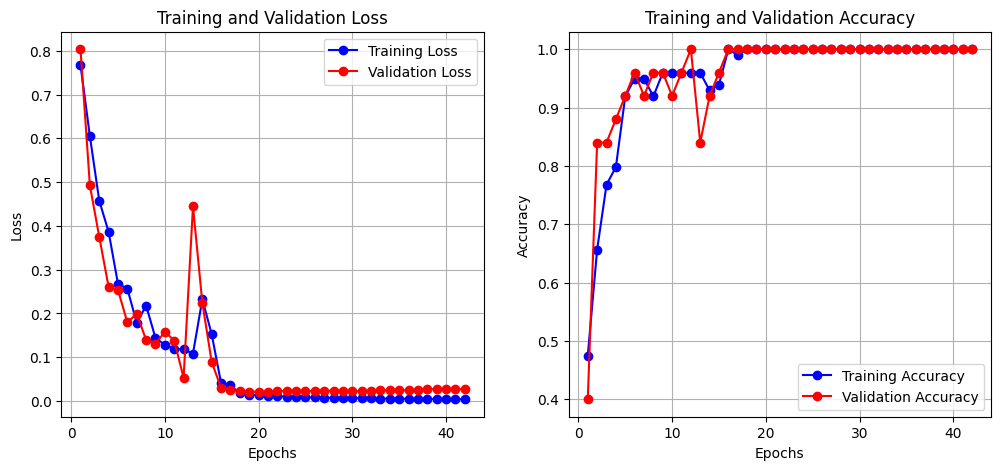

{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9590000033378601


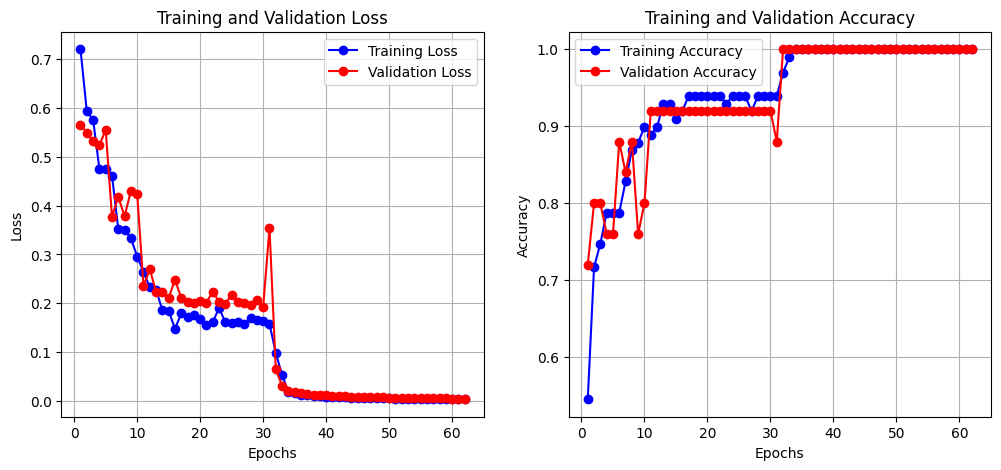

{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9433333277702332


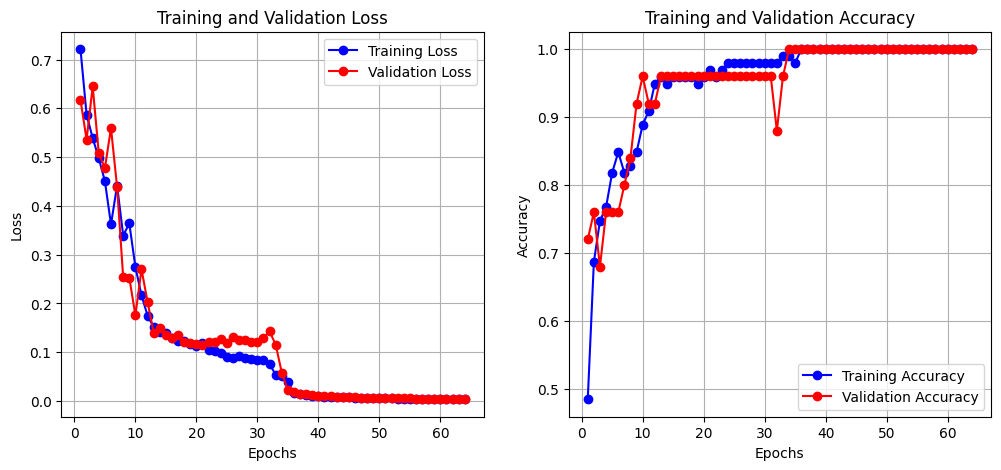

{'learning_rate': 0.3, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}
Score: 0.9429999947547912


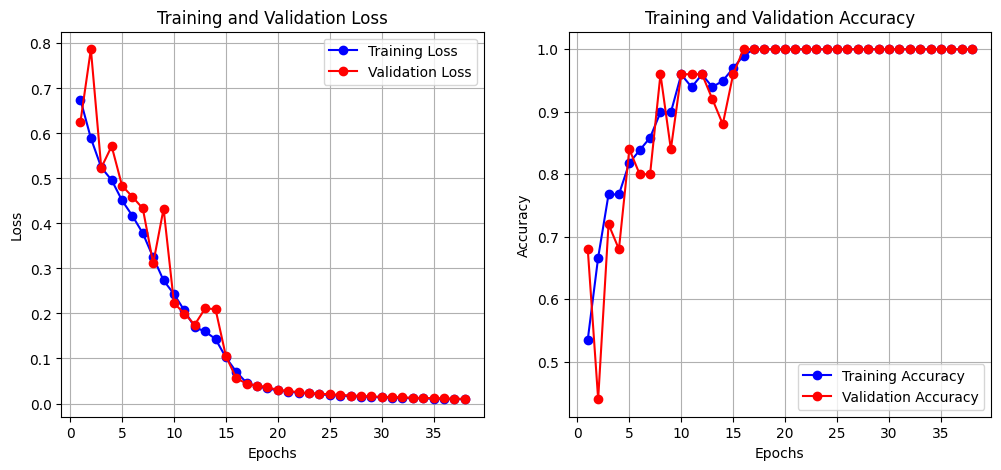

In [14]:
# Determine the input size from the encoded training data for monk1
input_size = X1_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_1 = {
    "learning_rate": (0.3, 0.5, 0.1),  # Learning rate from 0.1 to 0.5 with a step of 0.1
    "epochs": (180, 180, 1),           # Number of epochs fixed at 180
    "batch_size": (4, 4, 1),         # Batch size from 4 to 16 with a step of 12
    "hidden_size": (3, 3, 1),          # Number of nodes in hidden layers fixed at 3
    "hidden_layers": (1, 1, 1),        # Number of hidden layers fixed at 1
    "momentum": (0.4, 0.6, 0.1),       # Momentum from 0.4 to 0.6 with a step of 0.1
    "regularization": (0.001, 0.001, 0.005),  # Regularization factor fixed at 0.001
    "alpha": (0.01, 0.01, 0.01),       # Alpha for Leaky ReLU fixed at 0.01
    "patience": (30, 30, 1)            # Patience for early stopping fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk1 = generate_hyperparameter_combinations(param_ranges_1)

# Print a separator for clarity
print("--------------------------------------------------MONK 1--------------------------------------------------")

# Perform a greedy search over the hyperparameter grid for monk1 dataset
best_scores[0], best_params_list[0], best_models[0], best_histories[0] = greed_search(X1_train_encoded, y1_train, 
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, param_grid_monk1)

# Print a separator for clarity
print("--------------------------------------------------Plots--------------------------------------------------")

# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[0], best_params_list[0], best_scores[0])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the score
    plot_training_history(history)  # Plot the training history

--------------------------------------------------MONK 2--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 0.9176470518112183
--------------------------------------------------
Testing params: {'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 0.9470588207244873
--------------------------------------------------
Testing params: {'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7999999999999999, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score : 1.0
--------------------------------------------------
Testing params: {'learning_rate': 0.6, 'epochs': 180, 'batch_s

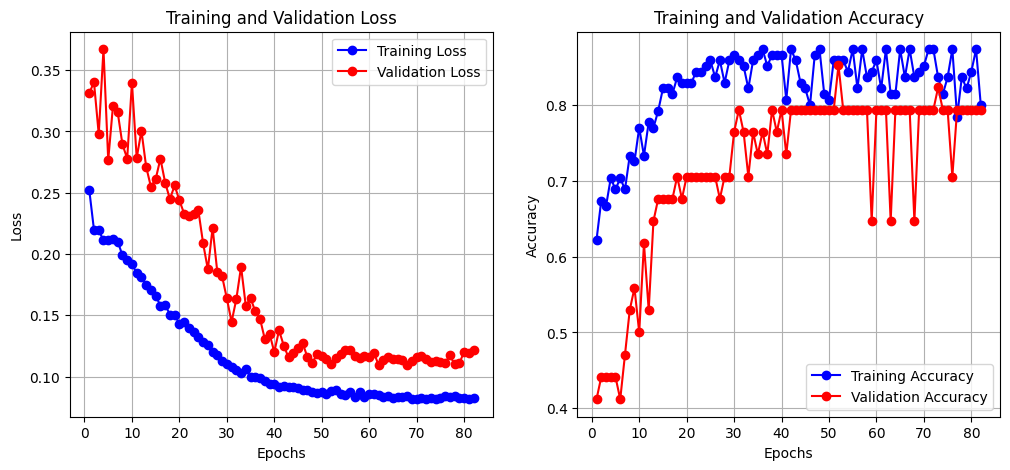

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 32, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8999999999999999, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.9882352948188782


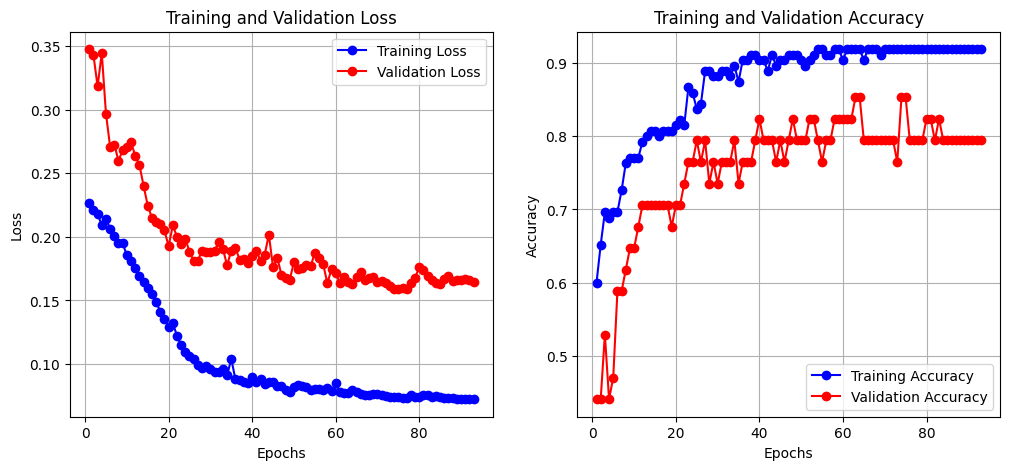

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 32, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7999999999999999, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.970588219165802


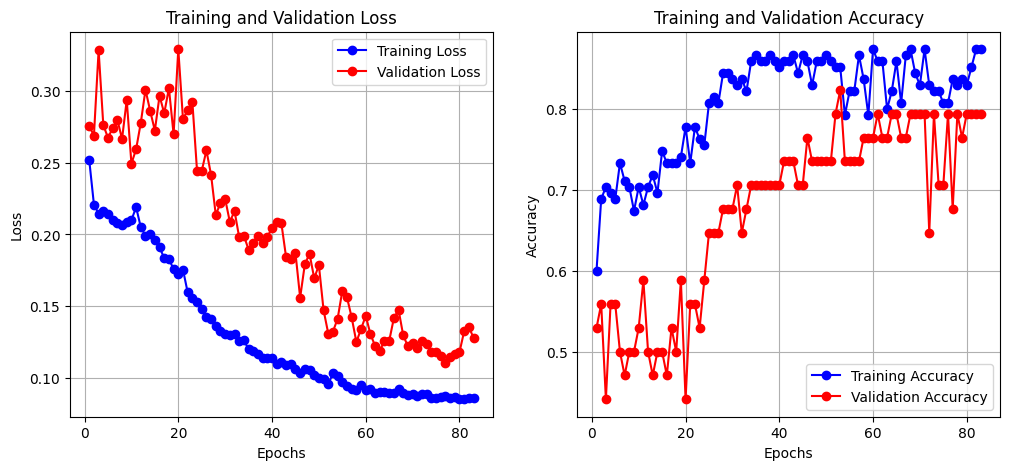

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.8999999999999999, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.9529411792755127


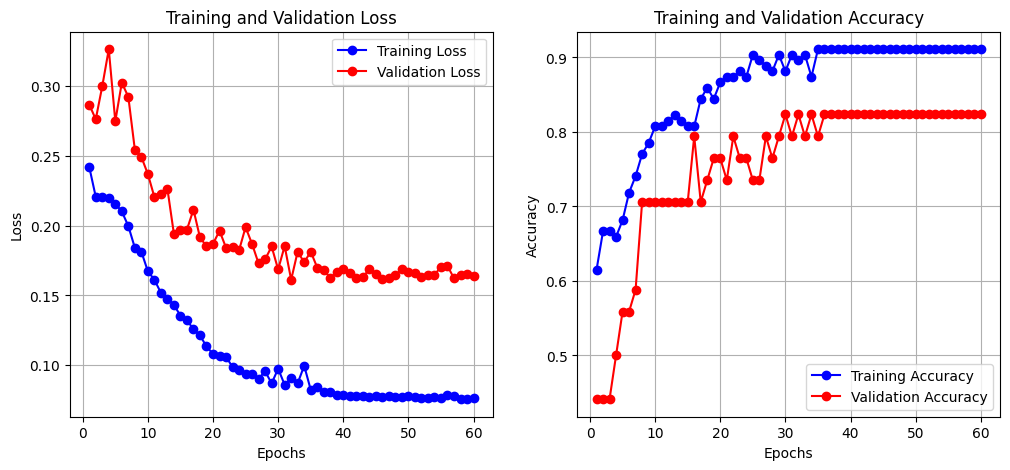

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.9470588207244873


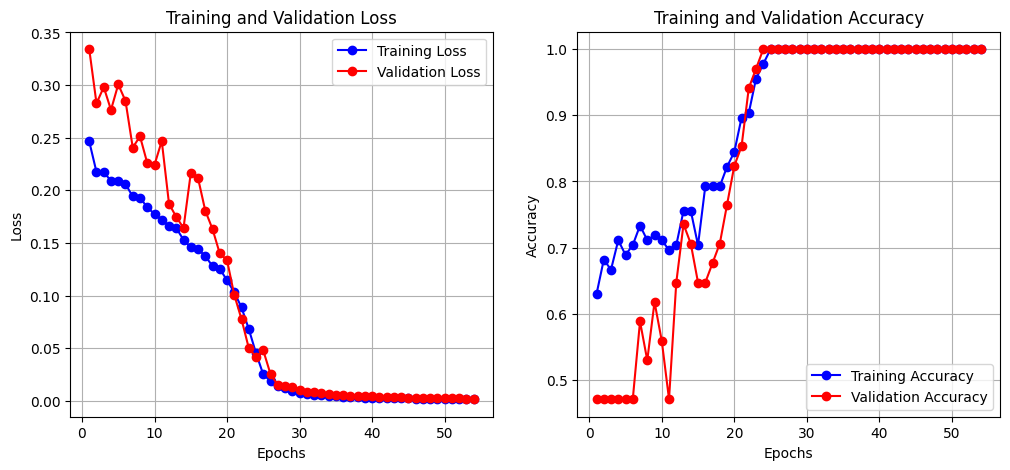

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.9176470518112183


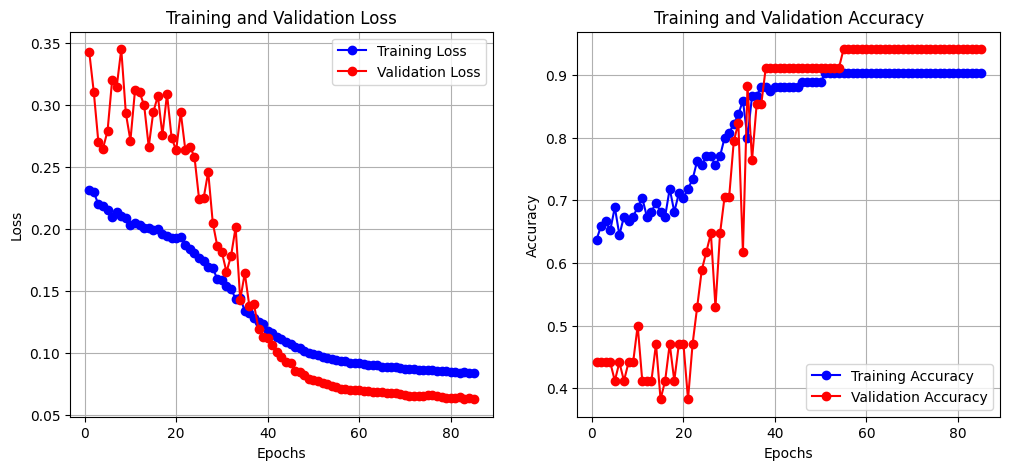

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 32, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.8764705896377564


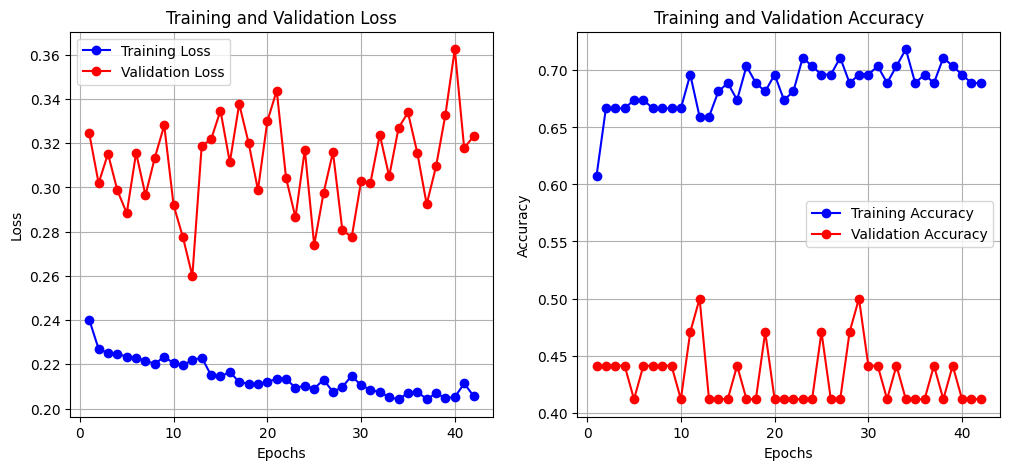

{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 32, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.01, 'alpha': 0.01, 'patience': 30}
Score: 0.8688056945800782


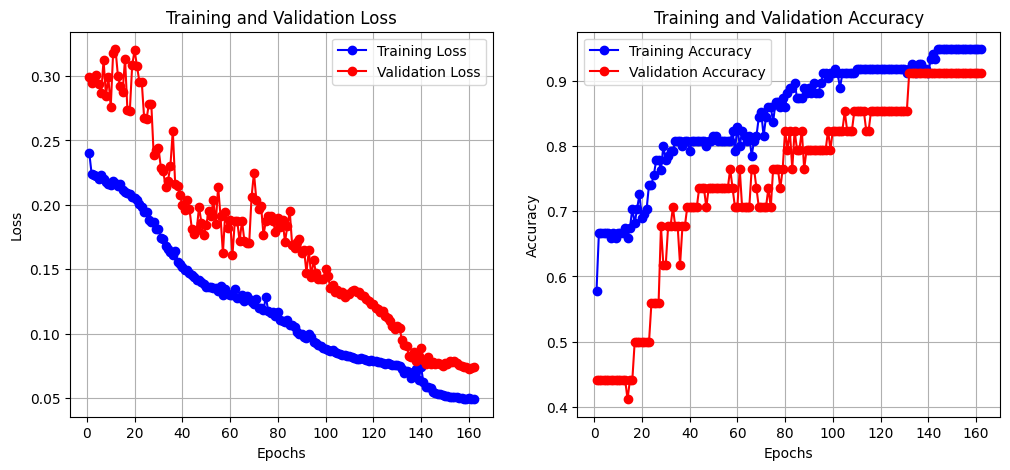

In [102]:
# Determine the input size from the encoded training data for monk2
input_size = X2_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_2 = {
    "learning_rate": (0.6, 0.6, 0.1),  # Learning rate fixed at 0.6
    "epochs": (180, 180, 1),           # Number of epochs fixed at 180
    "batch_size": (16, 32, 16),        # Batch size from 16 to 32 with a step of 16
    "hidden_size": (3, 3, 1),          # Number of nodes in hidden layers fixed at 3
    "hidden_layers": (1, 1, 1),        # Number of hidden layers fixed at 1
    "momentum": (0.6, 0.9, 0.1),       # Momentum from 0.6 to 0.9 with a step of 0.1
    "regularization": (0.01, 0.01, 0.05),  # Regularization factor fixed at 0.01
    "alpha": (0.01, 0.01, 0.01),       # Alpha for Leaky ReLU fixed at 0.01
    "patience": (30, 30, 1)            # Patience for early stopping fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk2 = generate_hyperparameter_combinations(param_ranges_2)

# Print a separator for clarity
print("--------------------------------------------------MONK 2--------------------------------------------------")

# Perform a greedy search over the hyperparameter grid for monk2 dataset
best_scores[1], best_params_list[1], best_models[1], best_histories[1] = greed_search(X2_train_encoded, y2_train,
                                                                                      'tanh', 'SGD', False, 
                                                                                      input_size, param_grid_monk2)

# Print a separator for clarity
print("--------------------------------------------------Plots--------------------------------------------------")

# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[1], best_params_list[1], best_scores[1])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the score
    plot_training_history(history)  # Plot the training history

--------------------------------------------------MONK 3--------------------------------------------------
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}


2025-01-25 18:34:05.997567: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-01-25 18:34:05.997629: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-01-25 18:34:05.997637: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-01-25 18:34:05.997829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-25 18:34:05.997851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-25 18:34:06.280202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Score : 0.934333324432373
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score : 0.934333324432373
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score : 0.934333324432373
--------------------------------------------------
Testing params: {'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7999999999999999, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score : 0.934333324432373
--------------------------------------------------
Testing params: {'learning_rate': 0.2, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, '

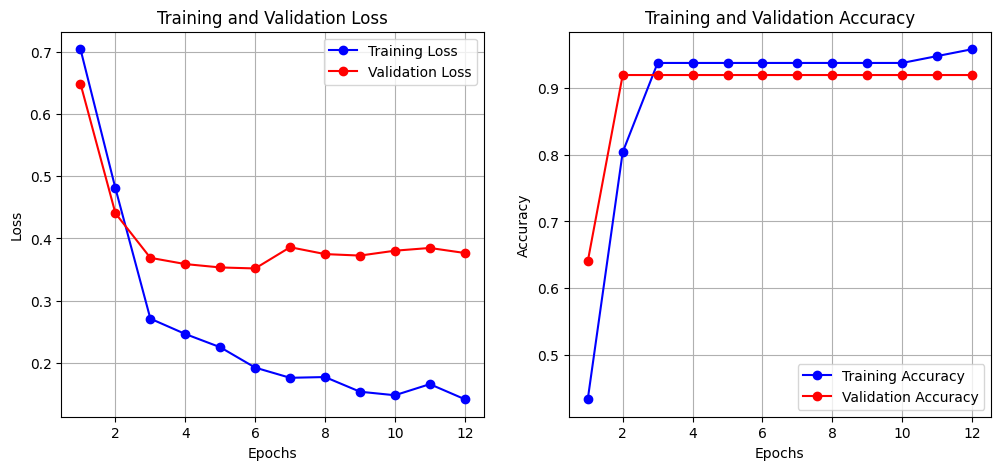

{'learning_rate': 0.2, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.9423333287239075


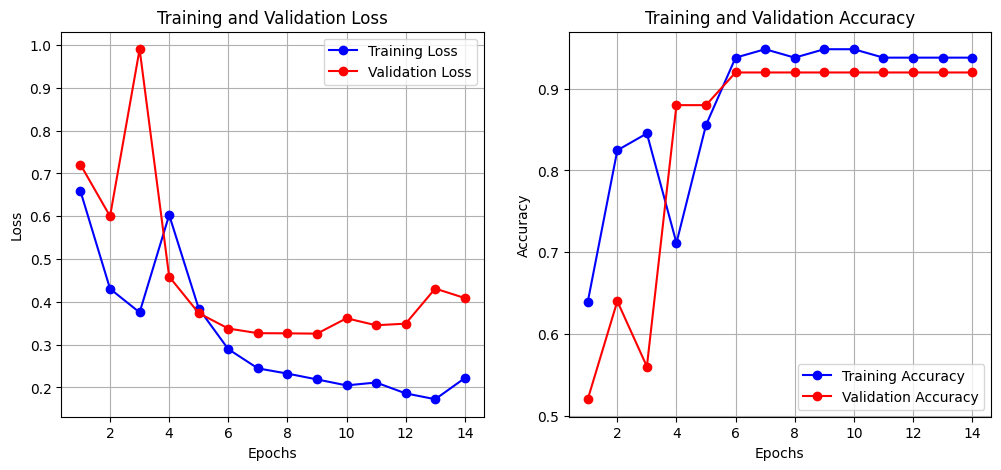

{'learning_rate': 0.2, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7999999999999999, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


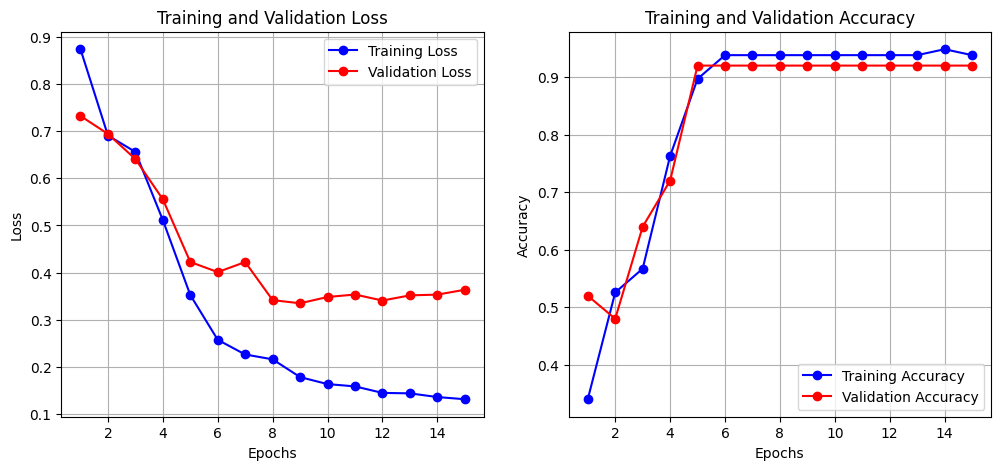

{'learning_rate': 0.2, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


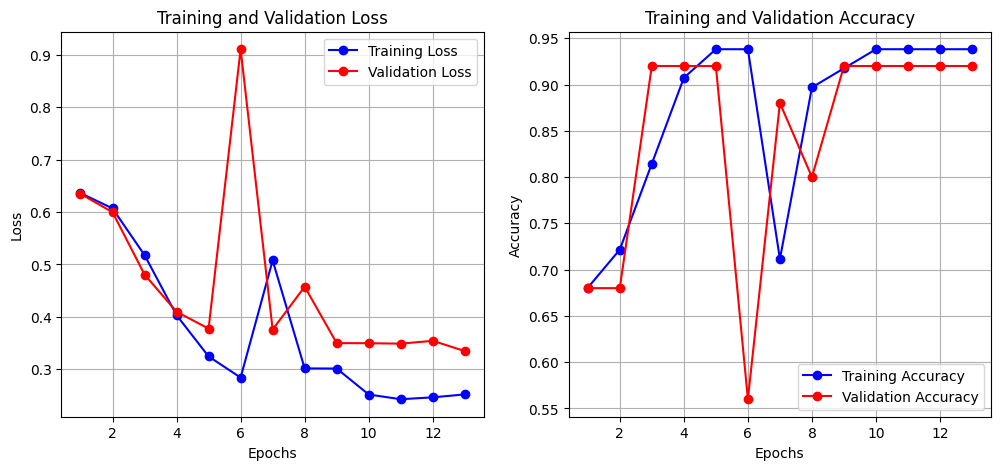

{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7999999999999999, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


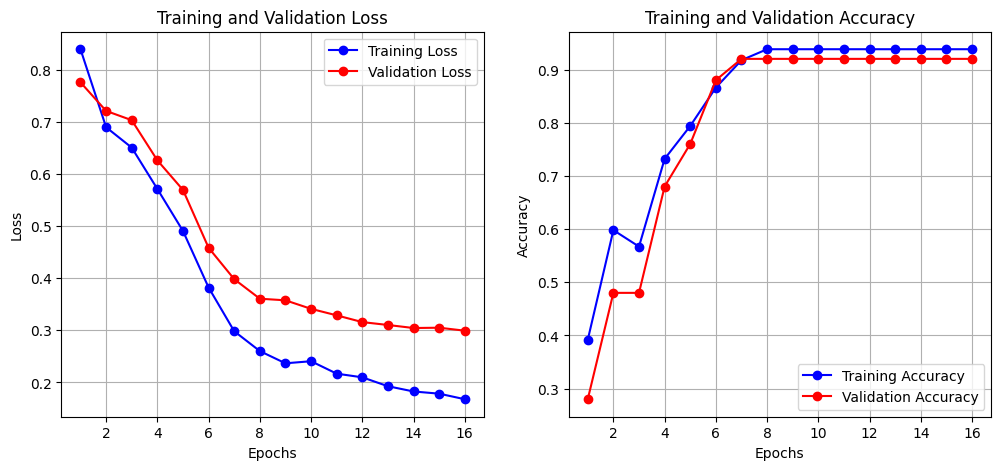

{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


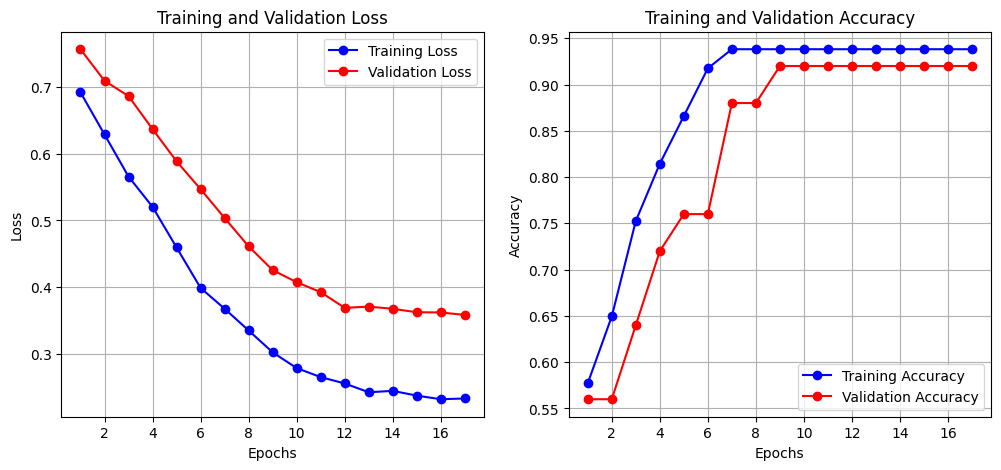

{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


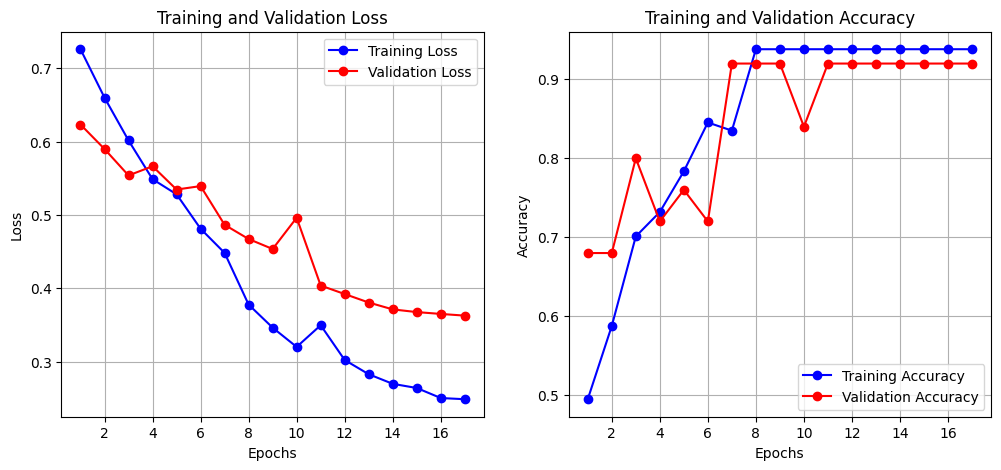

{'learning_rate': 0.1, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.7, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


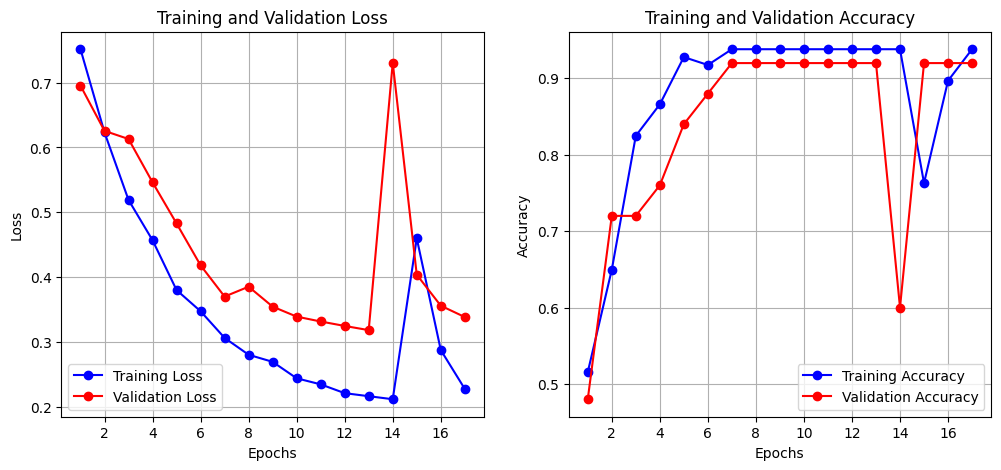

{'learning_rate': 0.2, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


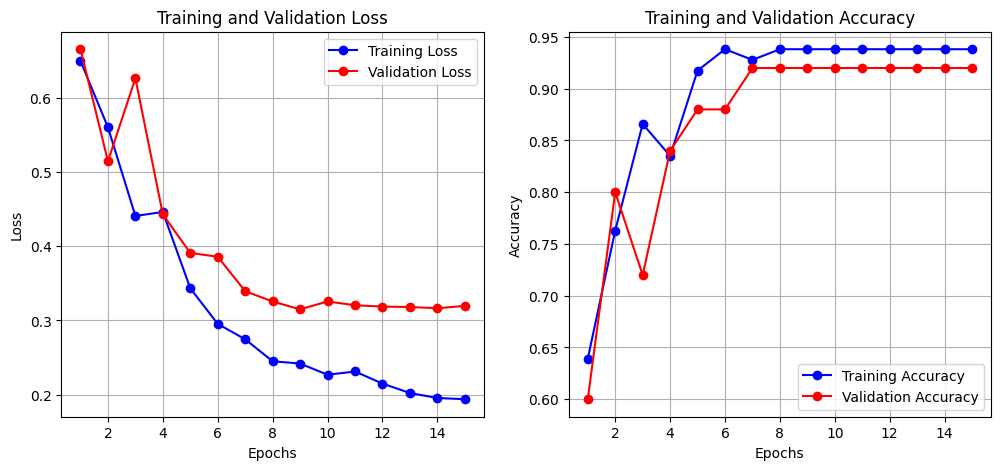

{'learning_rate': 0.30000000000000004, 'epochs': 180, 'batch_size': 16, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 10}
Score: 0.934333324432373


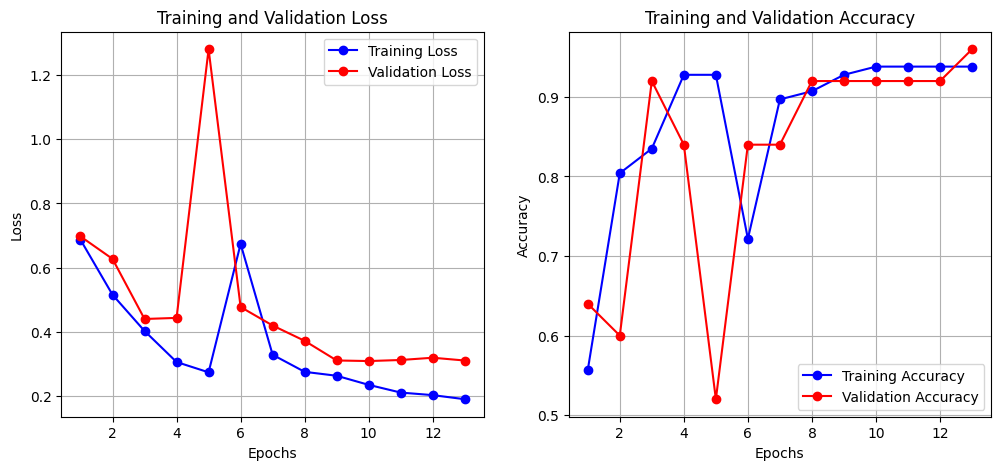

In [10]:
# Determine the input size from the encoded training data for monk3
input_size = X3_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges_3 = {
    "learning_rate": (0.1, 0.2, 0.1),  # Learning rate from 0.1 to 0.4 with a step of 0.1
    "epochs": (180, 180, 1),           # Number of epochs fixed at 180
    "batch_size": (16, 16, 6),         # Batch size fixed at 16
    "hidden_size": (3, 3, 1),          # Number of nodes in hidden layers fixed at 3
    "hidden_layers": (1, 1, 1),        # Number of hidden layers fixed at 1
    "momentum": (0.5, 0.8, 0.1),       # Momentum from 0.3 to 0.9 with a step of 0.1
    "regularization": (0.001, 0.001, 0.001),  # Regularization factor fixed at 0.001
    "alpha": (0.01, 0.01, 0.01),       # Alpha for Leaky ReLU fixed at 0.01
    "patience": (10, 10, 1)            # Patience for early stopping fixed at 10
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid_monk3 = generate_hyperparameter_combinations(param_ranges_3)

# Print a separator for clarity
print("--------------------------------------------------MONK 3--------------------------------------------------")

# Perform a greedy search over the hyperparameter grid for monk3 dataset
best_scores[2], best_params_list[2], best_models[2], best_histories[2] = greed_search(X3_train_encoded, y3_train,
                                                                                      'tanh', 'SGD', True, 
                                                                                      input_size, param_grid_monk3)

# Print a separator for clarity
print("--------------------------------------------------Plots--------------------------------------------------")

# Iterate over the best histories, parameters, and scores to print and plot the results
for i, (history, params, score) in enumerate(zip(best_histories[2], best_params_list[2], best_scores[2])):
    print(f"{params}")  # Print the hyperparameters
    print(f"Score: {score}")  # Print the score
    plot_training_history(history)  # Plot the training history

## Model assessment

In [13]:
best_models[2][4].evaluate(X3_test_encoded, y3_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9045 - auc: 0.9813 - loss: 0.3392


[0.32062554359436035, 0.9212962985038757, 0.9748989939689636]

In [31]:

# Determine the input size from the encoded training data for monk2
input_size = X3_train_encoded.shape[1]
output_size = 1

# Define the range of hyperparameters for the grid search
param_ranges = {
    "learning_rate": (0.6, 0.6, 0.1),  # Learning rate fixed at 0.6
    "epochs": (180, 180, 1),           # Number of epochs fixed at 180
    "batch_size": (16, 32, 16),        # Batch size from 16 to 32 with a step of 16
    "hidden_size": (3, 3, 1),          # Number of nodes in hidden layers fixed at 3
    "hidden_layers": (1, 1, 1),        # Number of hidden layers fixed at 1
    "momentum": (0.6, 0.9, 0.1),       # Momentum from 0.6 to 0.9 with a step of 0.1
    "regularization": (0.01, 0.01, 0.05),  # Regularization factor fixed at 0.01
    "alpha": (0.01, 0.01, 0.01),       # Alpha for Leaky ReLU fixed at 0.01
    "patience": (30, 30, 1)            # Patience for early stopping fixed at 30
}

# Generate all combinations of hyperparameters based on the specified ranges
param_grid = generate_hyperparameter_combinations(param_ranges)

double_k_fold_cross_validation(X3_train_encoded, y3_train, 'tanh', 'SGD', False, input_size, 5, 5, param_grid)

([1.0,
  0.8799999952316284,
  0.9583333134651184,
  0.9166666865348816,
  0.9583333134651184],
 [{'learning_rate': 0.6,
   'epochs': 180,
   'batch_size': 16,
   'hidden_size': 3,
   'hidden_layers': 1,
   'momentum': 0.7,
   'regularization': 0.01,
   'alpha': 0.01,
   'patience': 30},
  {'learning_rate': 0.6,
   'epochs': 180,
   'batch_size': 16,
   'hidden_size': 3,
   'hidden_layers': 1,
   'momentum': 0.6,
   'regularization': 0.01,
   'alpha': 0.01,
   'patience': 30},
  {'learning_rate': 0.6,
   'epochs': 180,
   'batch_size': 16,
   'hidden_size': 3,
   'hidden_layers': 1,
   'momentum': 0.7,
   'regularization': 0.01,
   'alpha': 0.01,
   'patience': 30},
  {'learning_rate': 0.6,
   'epochs': 180,
   'batch_size': 16,
   'hidden_size': 3,
   'hidden_layers': 1,
   'momentum': 0.6,
   'regularization': 0.01,
   'alpha': 0.01,
   'patience': 30},
  {'learning_rate': 0.6,
   'epochs': 180,
   'batch_size': 16,
   'hidden_size': 3,
   'hidden_layers': 1,
   'momentum': 0.6,
   '

**best paramters found at the moment (Adam, regularized, relu)**  
{'learning_rate': 0.6, 'epochs': 50, 'batch_size': 4, 'hidden_size': 2, 'hidden_layers': 1, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 10}  


**best paramters found at the moment (SGD, regularized, tanh)**  
**1**  
{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.5, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**2**  
{'learning_rate': 0.7, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.6000000000000001, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**3**:  
{'learning_rate': 0.4, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**7**  
{'learning_rate': 0.5, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.3, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
**8**  
{'learning_rate': 0.6, 'epochs': 180, 'batch_size': 4, 'hidden_size': 3, 'hidden_layers': 1, 'momentum': 0.4, 'regularization': 0.001, 'alpha': 0.01, 'patience': 30}  
